# Federated Mnist tests

Setup:
- 9 clusters with 1000 training images and 1000 test images (heterogeneously distributed) from mnist
- variable number of users for each cluster (chosen in the following code)
- in each communication round, all the users are active 
- each users has got a classification model and an estimation model
- each cluster has got a classification model and an estimation model
- in each communication round, some sort of aggregation is performed at the cluster level, then each cluster communicates with the server
- at the server side there are some data (homogeneously distributed, i.e. uniformly taken from the original mnist dataset) to perform a smart aggregation

Note:
- the distributed environment is simulated
- the performance can be measured in terms of local accuracy or global accuracy, on cluster test set or server-side test set

Author: Nicola Gulmini (nicolagulmini@gmail.com)

# Modules and parameters

In [1]:
!rm -r federated_learning
!git clone git://github.com/nicolagulmini/federated_learning

Cloning into 'federated_learning'...
remote: Enumerating objects: 52935, done.
remote: Counting objects: 100% (10069/10069), done.
remote: Compressing objects: 100% (10031/10031), done.
remote: Total 52935 (delta 206), reused 9823 (delta 37), pack-reused 42866
Receiving objects: 100% (52935/52935), 36.35 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (370/370), done.
Checking out files: 100% (54041/54041), done.


In [2]:
# from github
from federated_learning.utils import *
from federated_learning.aggregator_2 import *

# other libraries
from skimage import io
from skimage import transform
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from random import choice

In [3]:
# PARAMETERS
number_of_users = 45
number_of_clusters = 9 # according to the stored federated_mnist dataset

# local_epochs = 4 # default in federated setup class
# local_batch = 16 # default in federated setup class
communication_rounds = 30

# Initialization of the setup and the datasets

In [4]:
# definition of the setup with the central server and its datasets
server = server()
server.model = define_model_mnist().model
fed_setup = federated_setup(server)
fed_setup.server_side_dataset_generator(400, 400)

Server dataset setting completed.


In [5]:
# initialization of the clusters with the users assigned. This is the method that creates the setup, returning a list of clusters with no data
clusters = fed_setup.initialize_users_to_clusters(number_of_users, number_of_clusters)

Cluster number 0. User ids: [0, 1, 2, 3, 4]
Cluster number 1. User ids: [5, 6, 7, 8, 9]
Cluster number 2. User ids: [10, 11, 12, 13, 14]
Cluster number 3. User ids: [15, 16, 17, 18, 19]
Cluster number 4. User ids: [20, 21, 22, 23, 24]
Cluster number 5. User ids: [25, 26, 27, 28, 29]
Cluster number 6. User ids: [30, 31, 32, 33, 34]
Cluster number 7. User ids: [35, 36, 37, 38, 39]
Cluster number 8. User ids: [40, 41, 42, 43, 44]


Dataset load, rotating some images to make the learning more challenging

In [6]:
# take the images and the .csv labels from the dataset to numpy arrays
# note that the same process could be done with cifar10 (soon...)
clusters_train_data, clusters_test_data = [], []
datapath = "federated_learning/federated_mnist/federated_mnist_80/"
for i in range(number_of_clusters):
    cluster_data_path = datapath + str(i)
    train_path = cluster_data_path + "/training_images/"
    test_path = cluster_data_path + "/test_images/"
    ytrain = pd.read_csv(cluster_data_path + "/training_labels.csv", header=None, usecols=[1]).to_numpy().reshape(-1)
    ytest = pd.read_csv(cluster_data_path + "/test_labels.csv", header=None, usecols=[1]).to_numpy().reshape(-1)
    xtrain, xtest = [], []
    for img in range(len(ytrain)):
        xtrain.append(transform.rotate(io.imread(train_path + str(img) + ".png", as_gray=True), choice([0, 90, 180, 270])))
    for img in range(len(ytest)):
        xtest.append(transform.rotate(io.imread(test_path + str(img) + ".png", as_gray=True), choice([0, 90, 180, 270])))
    xtrain = array(xtrain)
    xtest = array(xtest)
    ytrain = array(ytrain)
    ytest = array(ytest)
    clusters_train_data.append({'cluster': i, 'images': xtrain, 'labels': ytrain})
    clusters_test_data.append({'cluster': i, 'images': xtest, 'labels': ytest})

In [7]:
# these methods assign data from the just loaded dataset to the clusters, and then from each cluster to its users
fed_setup.assign_dataset_to_clusters(clusters_train_data, clusters_test_data)
fed_setup.assign_clusters_data_to_users(verbose=0)

# initialize clusters models
for cluster in fed_setup.list_of_clusters:
    cluster.initialize_models()
    for user in cluster.users:
        user.initialize_classification_model()
    # then to transfer the cluster model to its users the transfer_cluster_model_to_users() method has to be used

# propagate from server to clusters the initial classification model
fed_setup.server_to_cluster_classification() # useless if local_updates=True then

Set data for cluster 0
Set data for cluster 1
Set data for cluster 2
Set data for cluster 3
Set data for cluster 4
Set data for cluster 5
Set data for cluster 6
Set data for cluster 7
Set data for cluster 8
Done.


# Aggregators

At the server side, we can implement different strategies to exploit the clusters models we have got, and try to obtain better performance than those already obtained.

In [8]:
# define the aggregator
server_agg = aggregator(len(fed_setup.list_of_clusters))
server_epochs = 1000
server_batch_size = 32

In [9]:
# to plot
server_aggregator_performance = []
genie_perf = [fed_setup.genie()]
local_acc = []
global_avg_softmax = [fed_setup.global_acc_of_avg_softmax_model()]
server_global_acc = [fed_setup.server.model.evaluate(fed_setup.server.x_test, fed_setup.server.y_test, verbose=0)[1]]
server_avg_local_acc = []
avg_local_local_models = []
avg_local_avg_softmax = [fed_setup.avg_softmax_on_local_datasets()]

# server aggregator perf only at the end
custom_x_train, custom_y_train, custom_x_val, custom_y_val = fed_setup.train_validation_split(fed_setup.server.x_train, server_agg.custom_y(fed_setup, fed_setup.server.x_train, fed_setup.server.y_train))
server_agg.model.fit(custom_x_train, custom_y_train, batch_size=server_batch_size, epochs=server_epochs, verbose=0, validation_data=(custom_x_val, custom_y_val))
# measure the global performance
server_aggregator_performance.append(server_agg.evaluation(fed_setup, fed_setup.server.x_test, fed_setup.server.y_test))
# measure the local performance
local_acc.append(server_agg.local_evaluation(fed_setup))

# other metrics
tmp_server_local_acc = 0
tmp_acc = 0
for cluster in fed_setup.list_of_clusters:
    tmp_server_local_acc += fed_setup.server.model.evaluate(cluster.test_data['images'], to_categorical(cluster.test_data['labels'], 10), verbose=0)[1]
    tmp_acc += cluster.get_model().evaluate(cluster.test_data['images'], to_categorical(cluster.test_data['labels'], 10), verbose=0)[1]
server_avg_local_acc.append(tmp_server_local_acc/len(fed_setup.list_of_clusters))
avg_local_local_models.append(tmp_acc/len(fed_setup.list_of_clusters))

# training
print("\nStart training.\n")
for round in range(communication_rounds):

    print("\n****** COMMUNICATION ROUND NUMBER " + str(round) + " START ******\n")
    # train
    avg_local_local_models_acc, tmp_server_global_acc = fed_setup.clustered_fed_avg_one_shot(local_updates=False)

    # returned metrics
    server_global_acc.append(tmp_server_global_acc)
    avg_local_local_models.append(avg_local_local_models_acc)

    # other metrics
    genie_perf.append(fed_setup.genie())
    global_avg_softmax.append(fed_setup.global_acc_of_avg_softmax_model())
    avg_local_avg_softmax.append(fed_setup.avg_softmax_on_local_datasets())

    # server aggregator perf only at the end
    custom_x_train, custom_y_train, custom_x_val, custom_y_val = fed_setup.train_validation_split(fed_setup.server.x_train, server_agg.custom_y(fed_setup, fed_setup.server.x_train, fed_setup.server.y_train))
    server_agg.model.fit(custom_x_train, custom_y_train, batch_size=server_batch_size, epochs=server_epochs, verbose=0, validation_data=(custom_x_val, custom_y_val))
    # measure the global performance
    server_aggregator_performance.append(server_agg.evaluation(fed_setup, fed_setup.server.x_test, fed_setup.server.y_test))
    # measure the local performance
    local_acc.append(server_agg.local_evaluation(fed_setup))

    # server model local performances
    tmp_server_local_acc = 0
    for cluster in fed_setup.list_of_clusters:
        tmp_server_local_acc += fed_setup.server.model.evaluate(cluster.test_data['images'], to_categorical(cluster.test_data['labels'], 10), verbose=0)[1]
    server_avg_local_acc.append(tmp_server_local_acc/len(fed_setup.list_of_clusters))


Start training.


****** COMMUNICATION ROUND NUMBER 0 START ******

* Server FedAvg method. If local_updates is True, at the beginning of this method, the same weights of the server model are set on each cluster model.
** Cluster number 0 training just started.
** Cluster number 1 training just started.
** Cluster number 2 training just started.
** Cluster number 3 training just started.
** Cluster number 4 training just started.
** Cluster number 5 training just started.
** Cluster number 6 training just started.
** Cluster number 7 training just started.
** Cluster number 8 training just started.
Server weights updated.

****** COMMUNICATION ROUND NUMBER 1 START ******

* Server FedAvg method. If local_updates is True, at the beginning of this method, the same weights of the server model are set on each cluster model.
** Cluster number 0 training just started.
** Cluster number 1 training just started.
** Cluster number 2 training just started.
** Cluster number 3 training just star

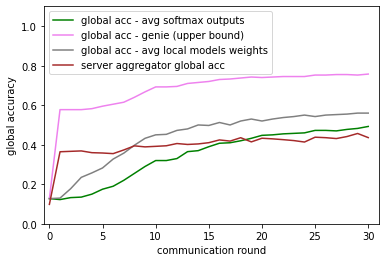

In [11]:
plt.figure()
plt.plot(range(communication_rounds+1), global_avg_softmax, label='global acc - avg softmax outputs', color='green')
plt.plot(range(communication_rounds+1), genie_perf, label='global acc - genie (upper bound)', color='violet')
plt.plot(range(communication_rounds+1), server_global_acc, label='global acc - avg local models weights', color='grey')
plt.plot(range(communication_rounds+1), local_acc, label='server aggregator global acc', color='brown')

plt.legend(loc="upper left")
plt.xlabel("communication round")
plt.ylabel("global accuracy")
plt.xlim(-.5, communication_rounds+1)
plt.ylim(0, 1.1)
plt.savefig('global.png')

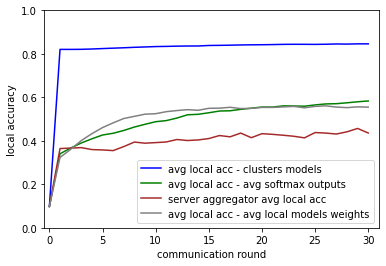

In [12]:
plt.figure()

plt.plot(range(communication_rounds+1), avg_local_local_models, label='avg local acc - clusters models', color='blue')
plt.plot(range(communication_rounds+1), avg_local_avg_softmax, label='avg local acc - avg softmax outputs', color='green')
plt.plot(range(communication_rounds+1), local_acc, label='server aggregator avg local acc', color='brown')
plt.plot(range(communication_rounds+1), server_avg_local_acc, label='avg local acc - avg local models weights', color='grey')

plt.legend(loc="lower right")
plt.xlabel("communication round")
plt.ylabel("local accuracy")
plt.xlim(-.5, communication_rounds+1)
plt.ylim(0, 1)
plt.savefig('local.png')